In [1]:
import sklearn
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from sklearn.ensemble import RandomTreesEmbedding, HistGradientBoostingRegressor, StackingRegressor, VotingRegressor
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor, RidgeCV, Ridge
from sklearn.model_selection import ParameterGrid, ParameterSampler, RandomizedSearchCV
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, KernelCenterer, RobustScaler
from sklearn.svm import SVR, LinearSVR, NuSVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, make_scorer, max_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import joblib
from sklearn.model_selection import cross_val_score, KFold, cross_validate, cross_val_predict
from sklearn.pipeline import make_pipeline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random, time
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error
from sklearn.linear_model import LinearRegression

## BEFORE PRUNING

In [3]:
df_all = pd.read_csv('z_score_3_data_all.csv')
x_all = df_all.drop(columns = ["V","α","β"])
y_all = df_all[["V","α","β"]]

x0_train, x0_test, y0_train, y0_test = train_test_split(x_all, y_all,
                                                        random_state = 42, test_size = 0.2)

In [4]:
def max_absolute_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred), axis=0)
scaler = StandardScaler()

# Base models (Level Pertama)
base_models = [
    # ('random_forest', RandomForestRegressor(n_estimators=250, max_depth=None, random_state=42, min_samples_leaf= 1, min_samples_split= 2, max_features = 'sqrt')),
    ('random_forest', RandomForestRegressor(n_estimators=100, random_state=21, max_leaf_nodes= 800)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=400, learning_rate=0.0579, random_state=42, max_depth = 5)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=2, weights='distance', algorithm='auto')))
]

meta_model = Ridge(alpha=0.1)

# Membentuk Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # Memasukkan data asli ke meta-model bersama prediksi base models
)

# Untuk multi-output, kita bungkus dengan MultiOutputRegressor
model_all_best = MultiOutputRegressor(stacking_regressor)
start = time.time()
# Training
model_all_best.fit(x0_train, y0_train)
end = time.time()
waktu = (end-start)/60
# Prediction
y0_pred = model_all_best.predict(x0_test)
r2 = r2_score(y0_test, y0_pred, multioutput = 'raw_values')
mae = mean_absolute_error(y0_test, y0_pred, multioutput = 'raw_values')
mse = mean_squared_error(y0_test, y0_pred, multioutput = 'raw_values')
max_ae = max_absolute_error(y0_test, y0_pred)
print(f'R2 : \n Alpha : {r2[1]} \n Beta : {r2[2]} \n V : {r2[0]} ')
print(f'MAE : \n Alpha : {mae[1]} \n Beta : {mae[2]} \n V : {mae[0]} ')
print(f'MSE : \n Alpha : {mse[1]} \n Beta : {mse[2]} \n V : {mse[0]} ')
print('Max AERR : \n', max_ae)
print("Waktu yang dibutuhkan : ", waktu)

R2 : 
 Alpha : 0.9999999813543439 
 Beta : 0.977405104213847 
 V : 0.9999997375615296 
MAE : 
 Alpha : 0.002604547261349629 
 Beta : 0.559077213592743 
 V : 0.0018585468821989413 
MSE : 
 Alpha : 2.4353795012336788e-05 
 Beta : 2.5045052507851886 
 V : 5.227615544605306e-05 
Max AERR : 
 V     0.084655
α     0.044422
β    15.077669
dtype: float64
Waktu yang dibutuhkan :  1.8378611564636231


In [5]:
y_cv_pred = cross_val_predict(model_all_best, x0_train, y0_train, cv=5)
print ('R2 V CV : ',(r2_score(y0_train['V'], y_cv_pred[:,0])))
print ('R2 Alpha CV : ',(r2_score(y0_train['α'], y_cv_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_train['β'], y_cv_pred[:,2])))
print ('R2 V Test : ',(r2_score(y0_test['V'], y0_pred[:,0])))
print ('R2 Alpha Test : ',(r2_score(y0_test['α'], y0_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_test['β'], y0_pred[:,2])))
print('MAE V CV : ', (mean_absolute_error(y0_train['V'], y_cv_pred[:,0])))
print('MAE Alpha CV : ', (mean_absolute_error(y0_train['α'], y_cv_pred[:,1])))
print('MAE Beta CV : ', (mean_absolute_error(y0_train['β'], y_cv_pred[:,2])))
print('MAE V Test : ', (mean_absolute_error(y0_test['V'], y0_pred[:,0])))
print('MAE Alpha Test : ', (mean_absolute_error(y0_test['α'], y0_pred[:,1])))
print('MAE Beta Test : ', (mean_absolute_error(y0_test['β'], y0_pred[:,2])))

R2 V CV :  0.999999645893315
R2 Alpha CV :  0.999995734306721
R2 Beta CV :  0.9729856186564232
R2 V Test :  0.9999997375615296
R2 Alpha Test :  0.9999999813543439
R2 Beta CV :  0.977405104213847
MAE V CV :  0.002196090116191652
MAE Alpha CV :  0.007985055469855189
MAE Beta CV :  0.6263375942493025
MAE V Test :  0.0018585468821989413
MAE Alpha Test :  0.002604547261349629
MAE Beta Test :  0.559077213592743


In [6]:
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),      
}
cv_scores = cross_validate(model_all_best, x0_train, y0_train, cv=5, scoring=scoring, return_train_score = True)

print("Cross-Validation R² Scores:", cv_scores['test_r2'])
print("Mean CV R² Score:", cv_scores['test_r2'].mean())

print("Cross-Validation MAE Scores:", -cv_scores['test_mae'])  
print("Mean CV MAE Score:", -cv_scores['test_mae'].mean())

test_score_r2 = model_all_best.score(x0_test, y0_test)
test_score_mae = mean_absolute_error(y0_test, y0_pred)
print("Test R² Score:", test_score_r2)
print(f"Test MAE: {test_score_mae:.6f}")

Cross-Validation R² Scores: [0.99249776 0.99251144 0.98917724 0.99023123 0.99051847]
Mean CV R² Score: 0.9909872278277527
Cross-Validation MAE Scores: [0.20391973 0.18715574 0.21509007 0.23566909 0.21903759]
Mean CV MAE Score: 0.21217444306148897
Test R² Score: 0.9924682743765735
Test MAE: 0.187847


In [31]:
y0_train_pred = model_all_best.predict(x0_train)
r2_train = r2_score(y0_train, y0_train_pred, multioutput = 'raw_values')
mae_train = mean_absolute_error(y0_train, y0_train_pred, multioutput = 'raw_values')
mse_train = mean_squared_error(y0_train, y0_train_pred, multioutput = 'raw_values')
max_ae_train = max_absolute_error(y0_train, y0_train_pred)
print(f'R2 : \n Alpha : {r2_train[1]} \n Beta : {r2_train[2]} \n V : {r2_train[0]} ')
print(f'MAE : \n Alpha : {mae_train[1]} \n Beta : {mae_train[2]} \n V : {mae_train[0]} ')
print(f'MSE : \n Alpha : {mse_train[1]} \n Beta : {mse_train[2]} \n V : {mse_train[0]} ')
print('Max AERR : \n', max_ae_train)

R2 : 
 Alpha : 0.9999999916337081 
 Beta : 0.9983851260887472 
 V : 0.9999999991885978 
MAE : 
 Alpha : 0.002011842106854503 
 Beta : 0.19145794251513748 
 V : 0.0002556734229209112 
MSE : 
 Alpha : 1.0290177668564654e-05 
 Beta : 0.17352914555041266 
 V : 1.6234064766187652e-07 
Max AERR : 
 V    0.002347
α    0.034644
β    4.160032
dtype: float64


In [5]:
y_pred_df = pd.DataFrame(y0_pred, columns = ["V","α","β"], index = y0_test.index)
y0_pred_10 = y_pred_df[(y_pred_df["V"] >= 8.5) & (y_pred_df["V"] <= 11.5)]
y0_pred_20 = y_pred_df[(y_pred_df["V"] >= 18.5) & (y_pred_df["V"] <= 21.5)]
y0_pred_30 = y_pred_df[(y_pred_df["V"] >= 28.5) & (y_pred_df["V"] <= 31.5)]
y0_pred_40 = y_pred_df[(y_pred_df["V"] >= 38.5) & (y_pred_df["V"] <= 41.5)]
y0_pred_50 = y_pred_df[(y_pred_df["V"] >= 48.5) & (y_pred_df["V"] <= 51.5)]

In [6]:
y0_test_10 = y0_test[(y0_test['V'] >= 8.5) & (y0_test['V'] <= 11.5)]
y0_test_20 = y0_test[(y0_test['V'] >= 18.5) & (y0_test['V'] <= 21.5)]
y0_test_30 = y0_test[(y0_test['V'] >= 28.5) & (y0_test['V'] <= 31.5)]
y0_test_40 = y0_test[(y0_test['V'] >= 38.5) & (y0_test['V'] <= 41.5)]
y0_test_50 = y0_test[(y0_test['V'] >= 48.5) & (y0_test['V'] <= 51.5)]

In [7]:
print(len(y0_test_10), len(y0_pred_10))
print(len(y0_test_20), len(y0_pred_20))
print(len(y0_test_30), len(y0_pred_30))
print(len(y0_test_40), len(y0_pred_40))
print(len(y0_test_50), len(y0_pred_50))
test = len(y0_test_10) + len(y0_test_20) + len(y0_test_30) + len(y0_test_40) + len(y0_test_50)
predict = len(y0_pred_10) + len(y0_pred_20) + len(y0_pred_30) + len(y0_pred_40) + len(y0_pred_50)
if test == predict :
    print('True')

274 274
278 278
278 278
253 253
266 266
True


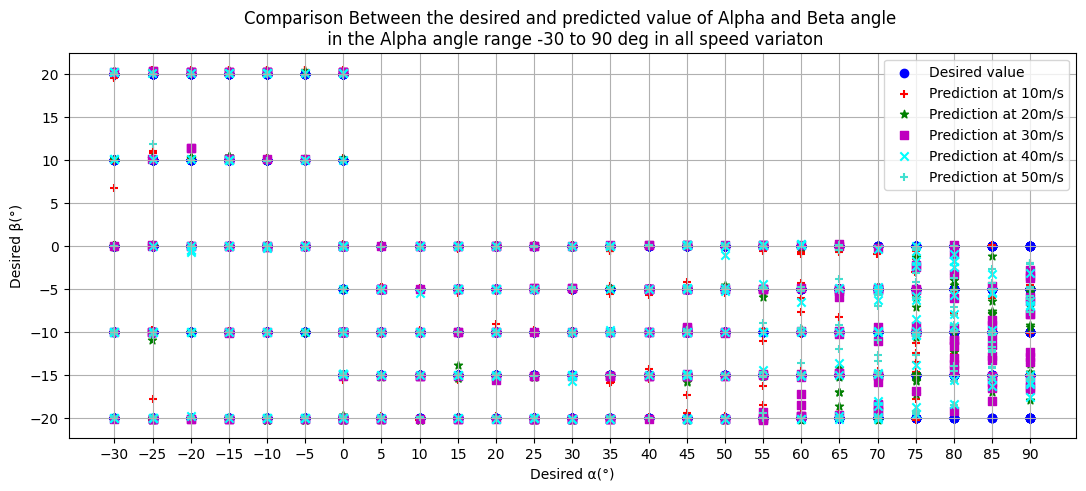

In [8]:
fig = plt.figure(figsize=(13, 5))

# Add first subplot (Alpha vs Beta)
ax1 = fig.add_subplot()
ax1.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
ax1.scatter(y0_pred_10["α"], y0_pred_10["β"], label = 'Prediction at 10m/s', marker='+', color='r')
ax1.scatter(y0_pred_20["α"], y0_pred_20["β"], label = 'Prediction at 20m/s', marker='*', color='green')
ax1.scatter(y0_pred_30["α"], y0_pred_30["β"], label = 'Prediction at 30m/s', marker='s', color='m')
ax1.scatter(y0_pred_40["α"], y0_pred_40["β"], label = 'Prediction at 40m/s', marker='x', color='cyan')
ax1.scatter(y0_pred_50["α"], y0_pred_50["β"], label = 'Prediction at 50m/s', marker='+', color='turquoise')
ax1.set_xlabel("Desired α(°)")
ax1.set_ylabel("Desired β(°)")
ax1.set_xticks(np.arange(-30, 95, 5))
ax1.set_yticks(np.arange(-20, 25, 5))
ax1.set_title('Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg in all speed variaton')
ax1.grid(True)
ax1.legend()

plt.savefig('model_2_all_before_pruning.png', format='png', dpi=1000)
plt.show()

In [9]:
# y_pred = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# fig, axes = plt.subplots(5, 1, figsize=(10,30))
# speed = 10
# # Add first subplot (Alpha vs Beta)
# for i, V in enumerate(y_pred):
#     ax = axes[i]
#     ax.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
#     ax.scatter(V["α"], V["β"], label = f'Prediction at {speed} m/s', marker='+', color='r')
#     ax.set_xlabel("Desired α(°)")
#     ax.set_ylabel("Desired β(°)")
#     ax.set_xticks(np.arange(-30, 95, 5))
#     ax.set_yticks(np.arange(-20, 25, 5))
#     ax.set_title(f'Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg for {speed} m/s')
#     ax.grid(True)
#     speed += 10
    

# plt.savefig('model_2_every_before_pruning.png', format='png', dpi=1000)
# plt.tight_layout()
# plt.show()

0.04028938448503183 604 
 V              10.002965
α              25.000000
β             -20.000000
alpha_error     0.040289
Name: 604, dtype: float64
-0.035566499509466 231 
 V              10.013257
α             -10.000000
β              10.000000
alpha_error    -0.035566
Name: 231, dtype: float64
0.02702002253958824 2154 
 V              20.035432
α              45.000000
β             -20.000000
alpha_error     0.027020
Name: 2154, dtype: float64
-0.04442198937633002 1891 
 V              20.054249
α              15.000000
β               0.000000
alpha_error    -0.044422
Name: 1891, dtype: float64
0.004825955925369385 3487 
 V              30.005920
α              40.000000
β              -5.000000
alpha_error     0.004826
Name: 3487, dtype: float64
-0.01992420988743504 3705 
 V              30.022906
α              60.000000
β             -20.000000
alpha_error    -0.019924
Name: 3705, dtype: float64
0.04428182375104939 5354 
 V              40.071150
α              90.000000
β

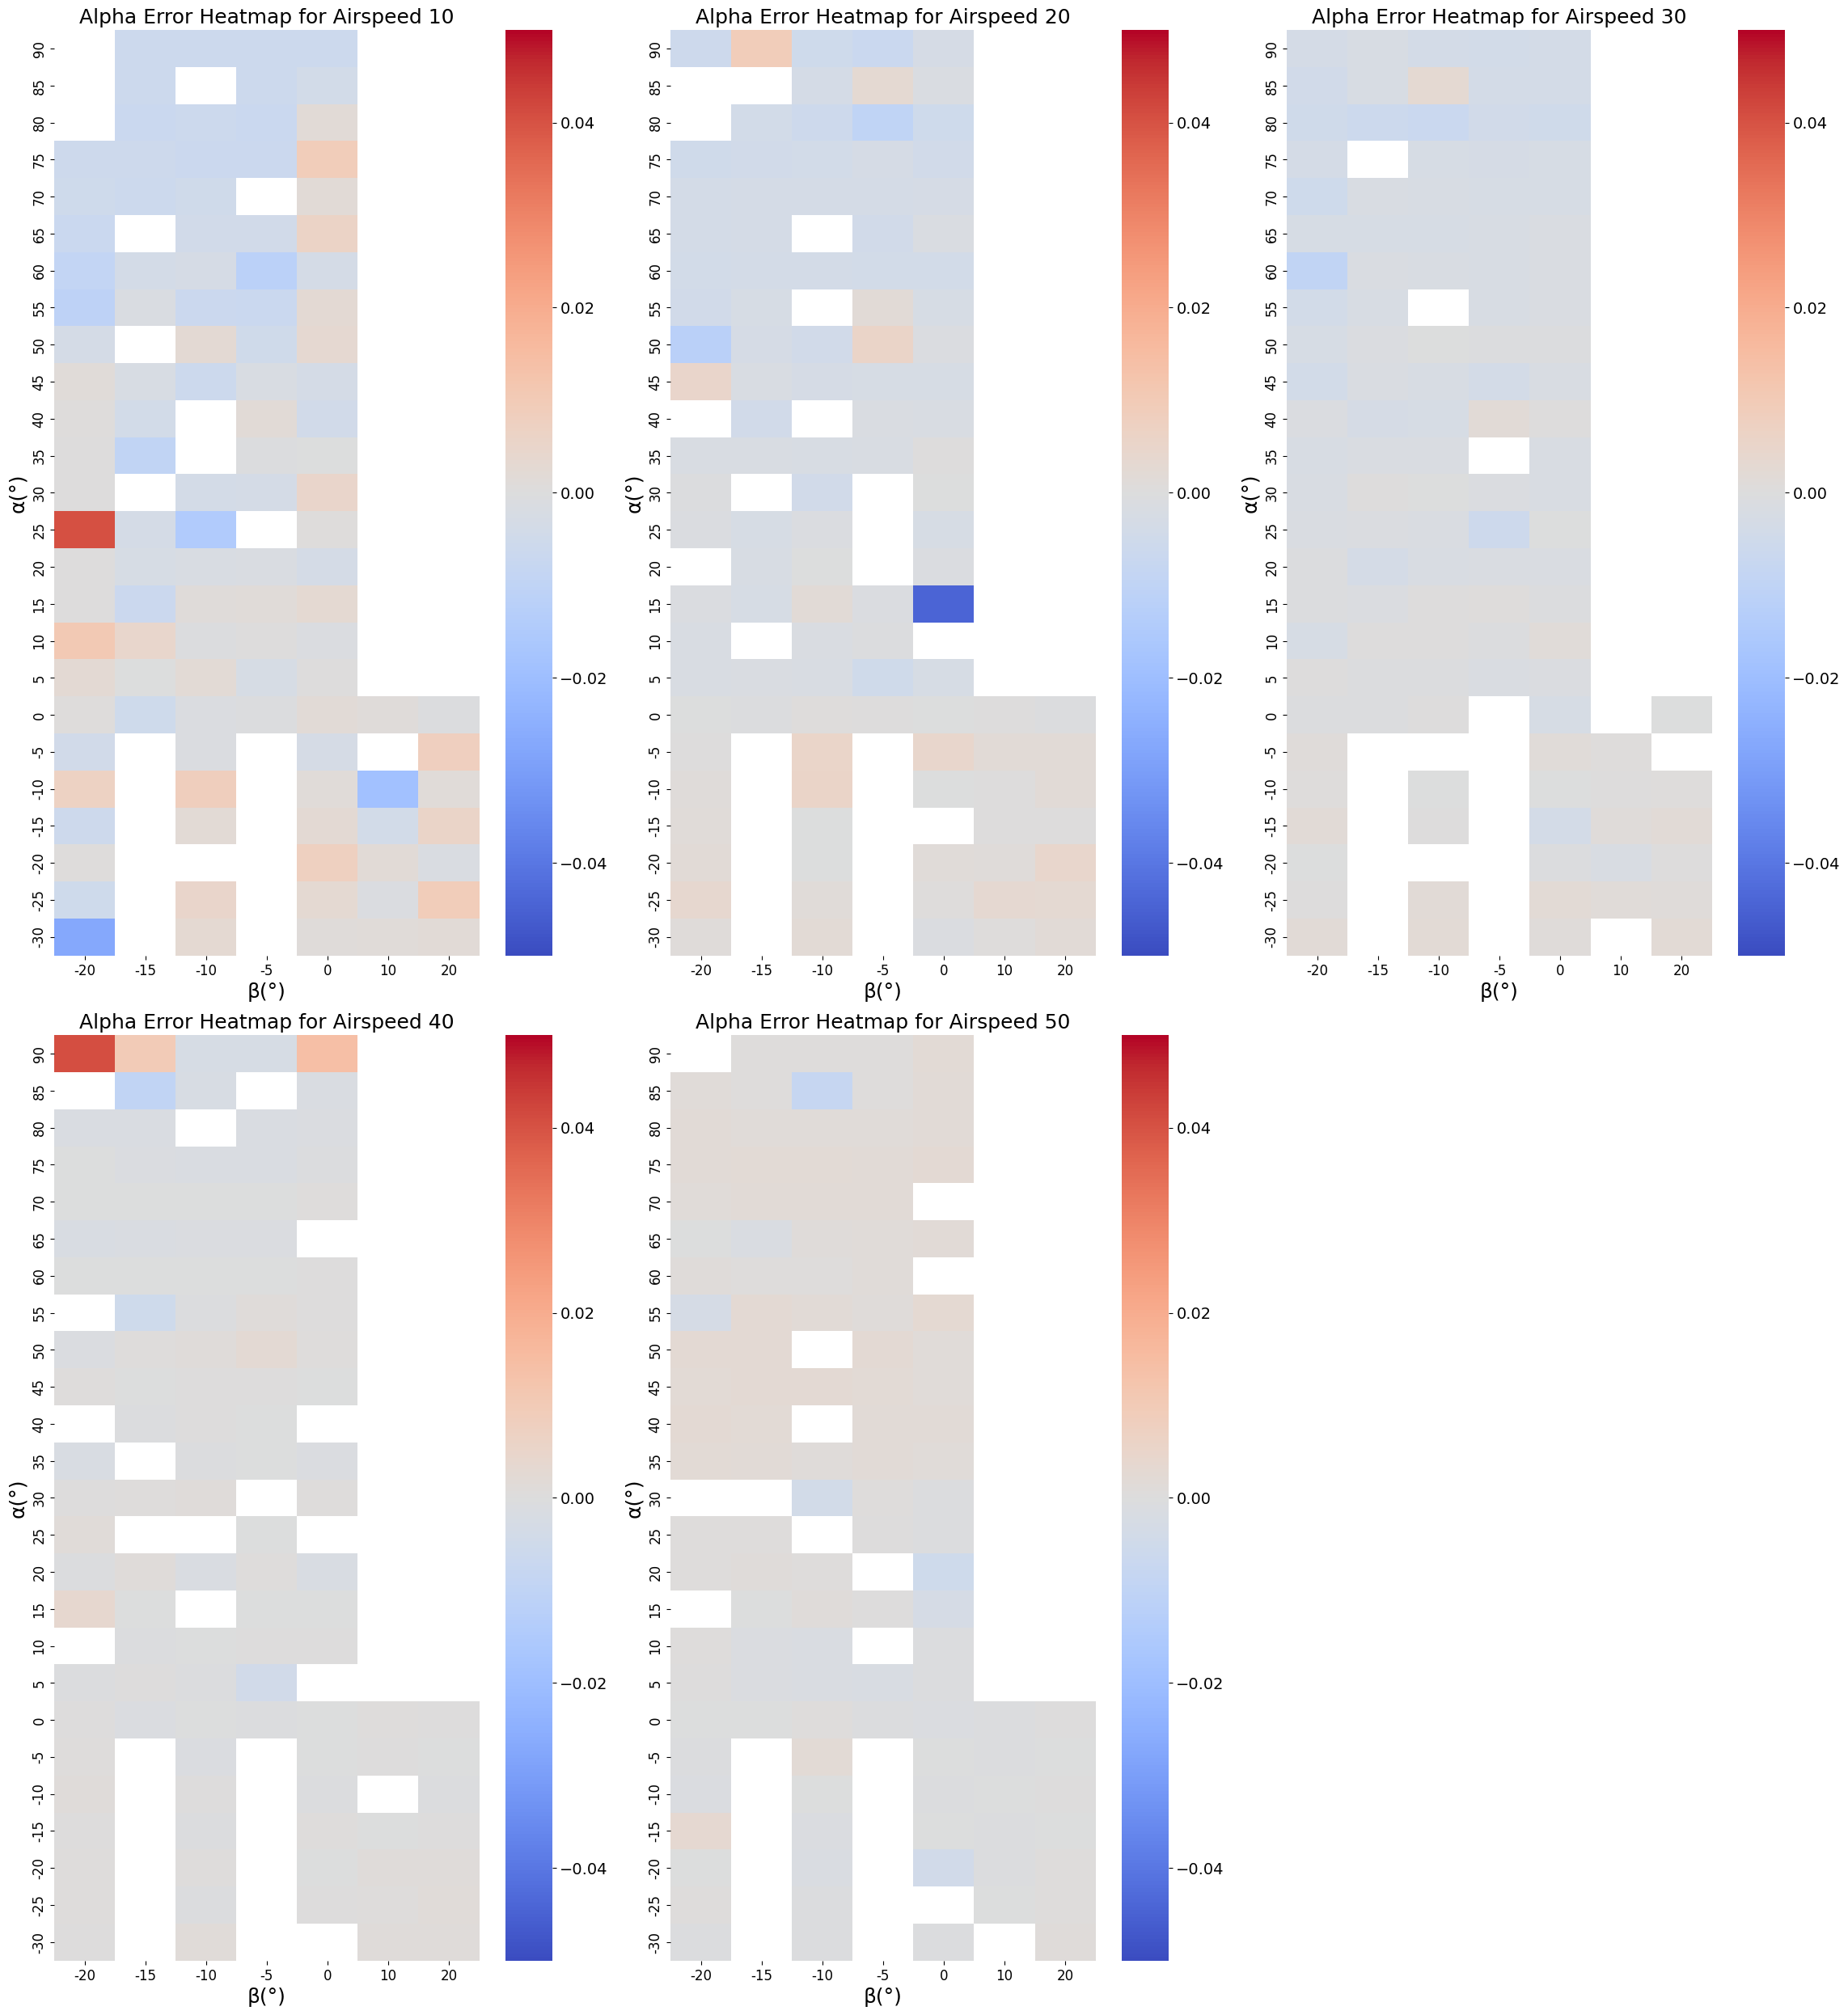

In [10]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    print(actual['alpha_error'].max(), actual['alpha_error'].idxmax(), '\n', actual.loc[actual['alpha_error'].idxmax()] )
    print(actual['alpha_error'].min(), actual['alpha_error'].idxmin(), '\n', actual.loc[actual['alpha_error'].idxmin()] )
    actual['beta_error'] = beta_values_act - beta_values_pred
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='alpha_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -0.05,
        vmax = 0.05
    )
    ax.set_title(f'Alpha Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_2_heatmap_alpha_before_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()

7.462057271481321 1181 
 V              10.023695
α              75.000000
β              -5.000000
alpha_error    -0.006959
beta_error      7.462057
Name: 1181, dtype: float64
-8.902405623045595 1261 
 V              10.087213
α              85.000000
β             -15.000000
alpha_error    -0.005926
beta_error     -8.902406
Name: 1261, dtype: float64
13.75609628094519 2697 
 V              20.019834
α              90.000000
β               0.000000
alpha_error    -0.001308
beta_error     13.756096
Name: 2697, dtype: float64
-15.077668537328657 2653 
 V              20.027975
α              90.000000
β             -20.000000
alpha_error    -0.005285
beta_error    -15.077669
Name: 2653, dtype: float64
10.109302940864527 3985 
 V              30.065874
α              85.000000
β              -5.000000
alpha_error    -0.002113
beta_error     10.109303
Name: 3985, dtype: float64
-7.644867254543655 3997 
 V              30.038176
α              90.000000
β             -20.000000
alpha_erro

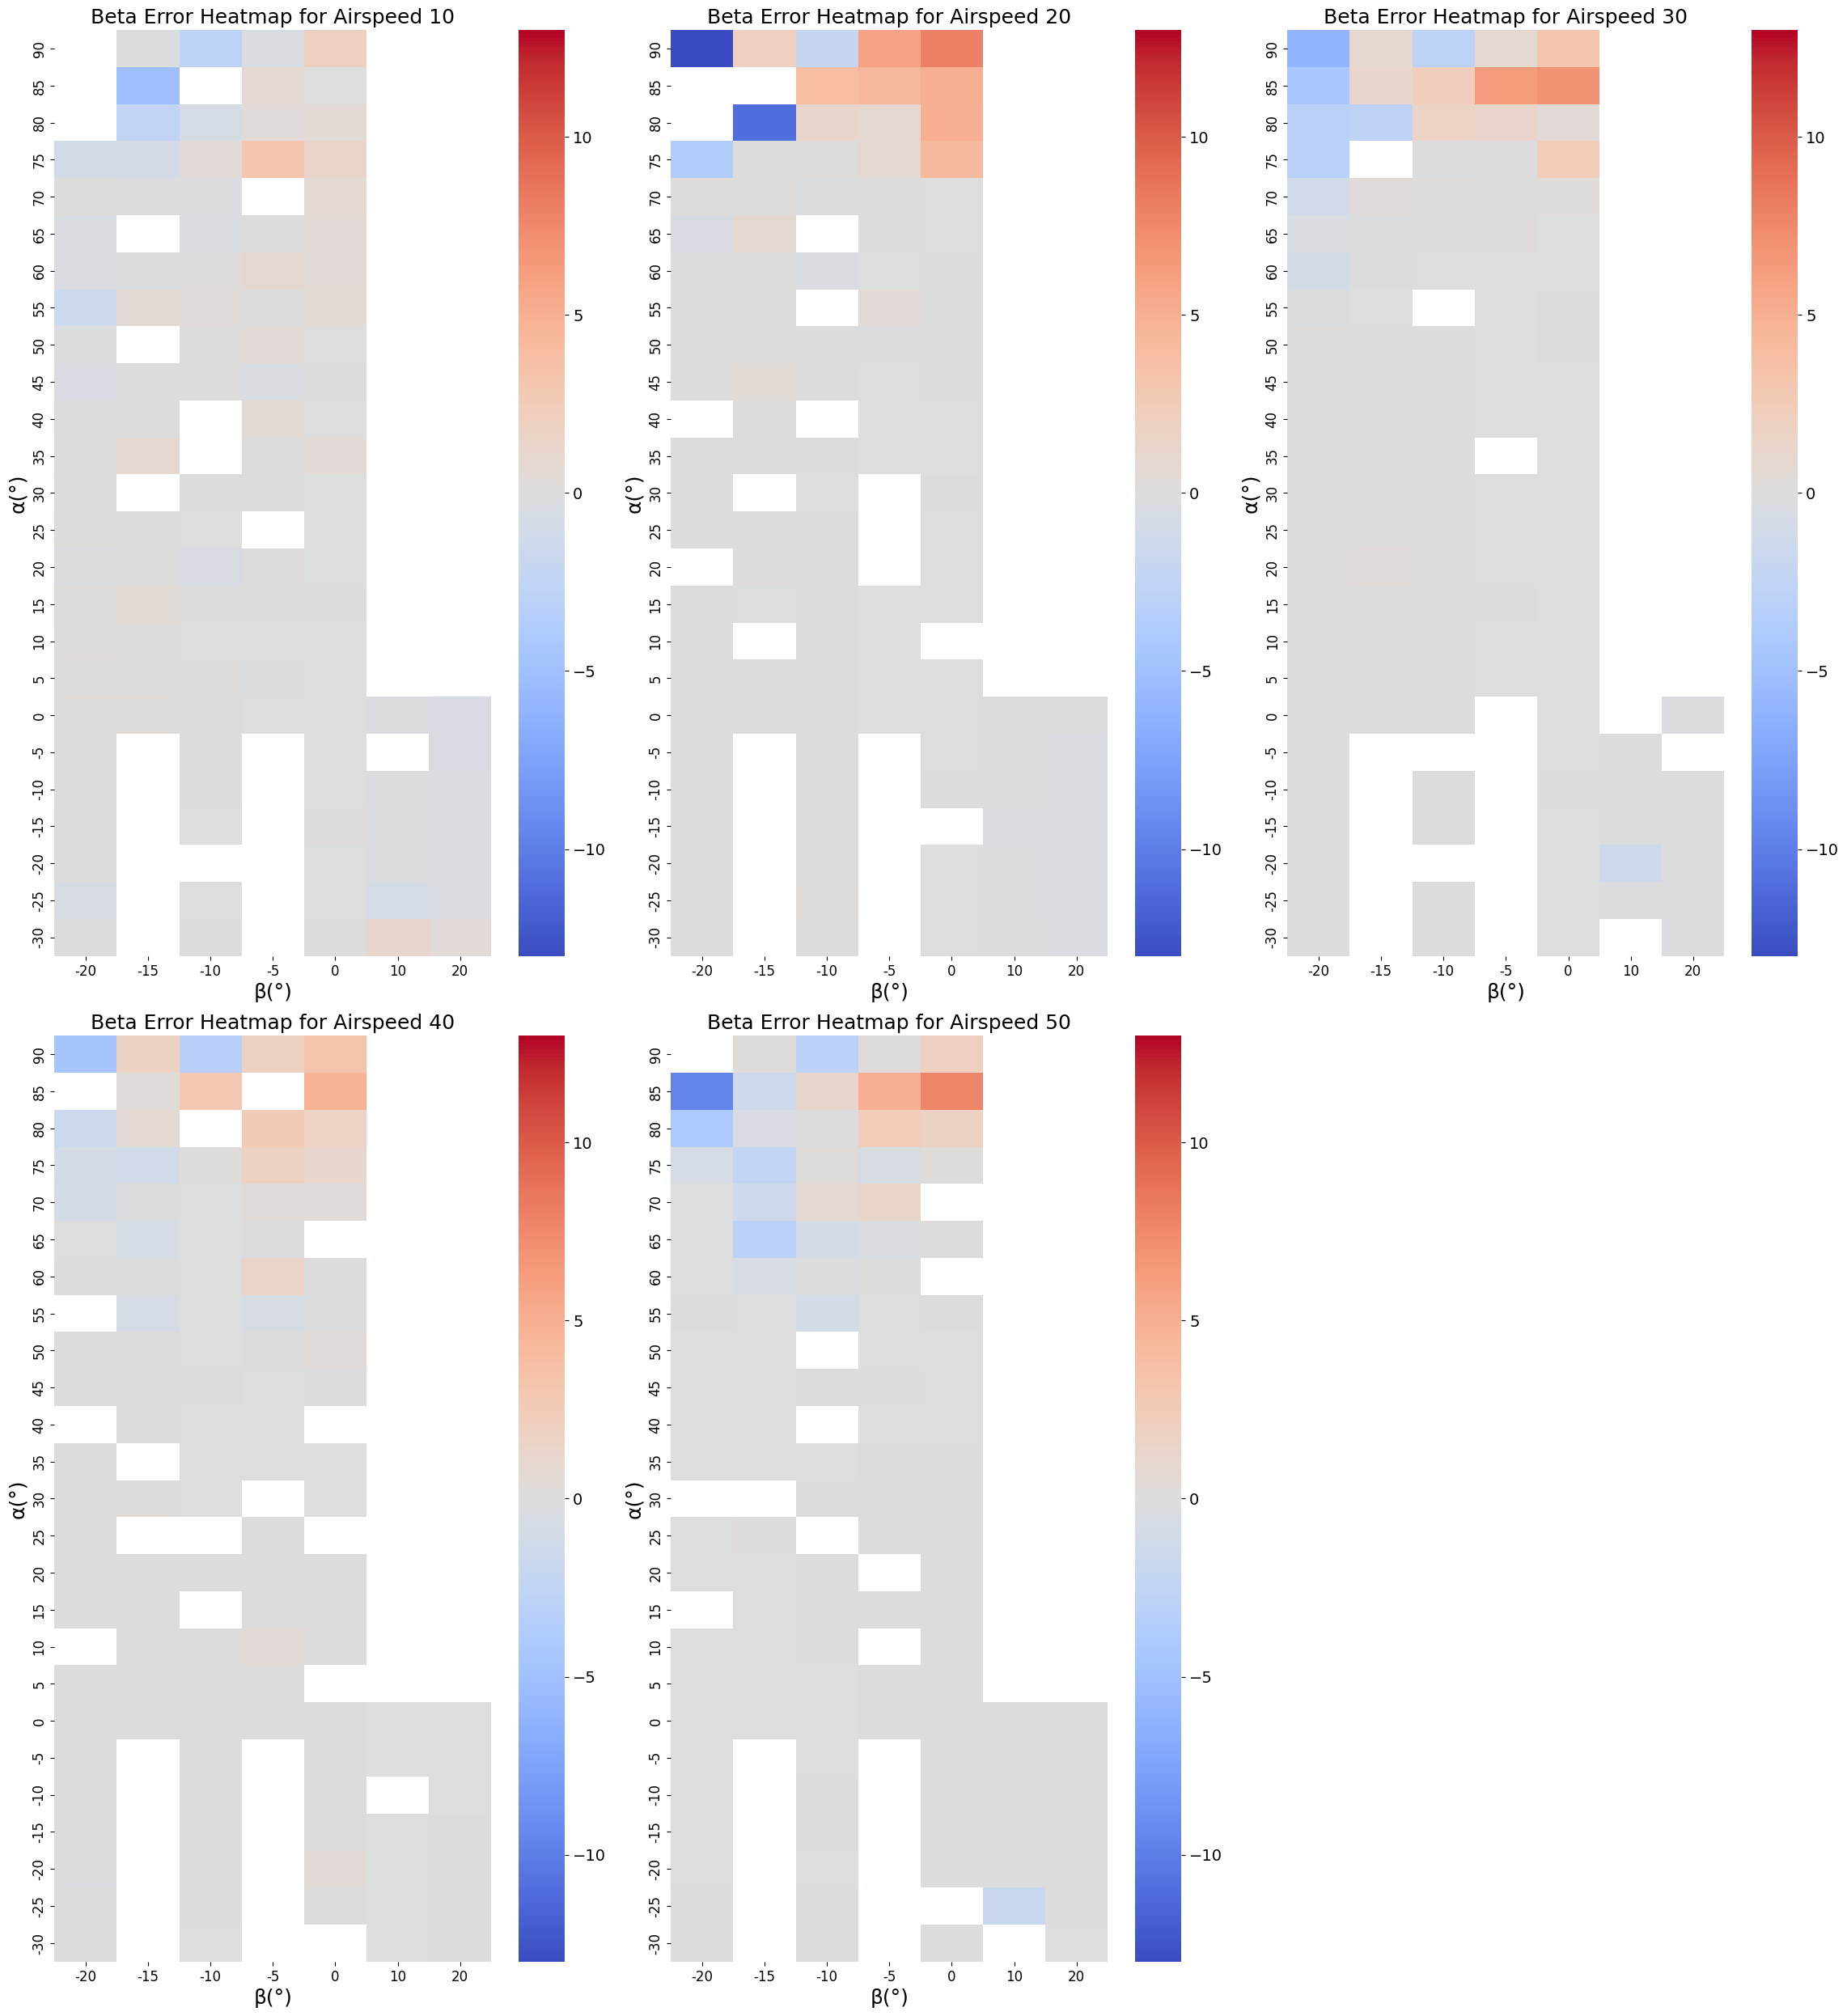

In [11]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    actual['beta_error'] = beta_values_act - beta_values_pred
    print(actual['beta_error'].max(), actual['beta_error'].idxmax(), '\n', actual.loc[actual['beta_error'].idxmax()] )
    print(actual['beta_error'].min(), actual['beta_error'].idxmin(), '\n', actual.loc[actual['beta_error'].idxmin()] )
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -13,
        vmax = 13
    )
    ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_2_heatmap_beta_before_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()
# pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

# fig, axes = plt.subplots(2, 3, figsize=(20, 15))
# axes = axes.flatten()
# for i in range(len(pred_result)):
#     actual = act_result[i].copy()
#     alpha_values_pred = pred_result[i]["α"]
#     beta_values_pred = pred_result[i]["β"]
#     alpha_values_act = act_result[i]["α"]
#     beta_values_act = act_result[i]["β"]
#     actual['alpha_error'] = alpha_values_act - alpha_values_pred
#     actual['beta_error'] = beta_values_act - beta_values_pred
#     ax = axes[i]
#     pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
#     sns.heatmap(
#         pivot_table,
#         cmap='coolwarm',
#         ax = axes [i],
#     )
#     ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}')
#     ax.set_xlabel("β(°)")
#     ax.set_ylabel("α(°)")
#     ax.invert_yaxis()
# for j in range(len(pred_result), len(axes)):
#     axes[j].axis('off')
# plt.savefig('model_1_heatmap_beta_before_pruning.png', format='png', dpi=1500)
# plt.tight_layout(rect=[0, 0, 0.9, 1]) 
# plt.show()

## AFTER PRUNING

In [32]:
df_all = pd.read_csv('data_clean_reduce_21_z_score_3_sec.csv')
x_all = df_all.drop(columns = ["V","α","β"])
y_all = df_all[["V","α","β"]]

x0_train, x0_test, y0_train, y0_test = train_test_split(x_all, y_all,
                                                        random_state = 42, test_size = 0.2)

In [33]:
def max_absolute_error(y_true, y_pred):
    return np.max(np.abs(y_true - y_pred), axis=0)
scaler = StandardScaler()

# Base models (Level Pertama)
base_models = [
    # ('random_forest', RandomForestRegressor(n_estimators=250, max_depth=None, random_state=42, min_samples_leaf= 1, min_samples_split= 2, max_features = 'sqrt')),
    ('random_forest', RandomForestRegressor(n_estimators=100, max_depth=None, random_state=21, max_leaf_nodes= 800)),
    ('gradient_boosting', GradientBoostingRegressor(n_estimators=400, learning_rate=0.0579, random_state=42, max_depth = 5)),
    ('knn', make_pipeline(StandardScaler(), KNeighborsRegressor(n_neighbors=2, weights='distance', algorithm='auto')))
]

# Meta-model (Level Kedua)
# Menggunakan Ridge Regression sebagai meta-model untuk menghindari overfitting
meta_model = Ridge(alpha=0.1)

# Membentuk Stacking Regressor
stacking_regressor = StackingRegressor(
    estimators=base_models,
    final_estimator=meta_model,
    passthrough=True  # Memasukkan data asli ke meta-model bersama prediksi base models
)

# Untuk multi-output, kita bungkus dengan MultiOutputRegressor
model_all_best = MultiOutputRegressor(stacking_regressor)
start = time.time()
# Training
model_all_best.fit(x0_train, y0_train)
end = time.time()
waktu = (end-start)/60
# Prediction
y0_pred = model_all_best.predict(x0_test)
r2 = r2_score(y0_test, y0_pred, multioutput = 'raw_values')
mae = mean_absolute_error(y0_test, y0_pred, multioutput = 'raw_values')
mse = mean_squared_error(y0_test, y0_pred, multioutput = 'raw_values')
max_ae = max_absolute_error(y0_test, y0_pred)
print(f'R2 : \n Alpha : {r2[1]} \n Beta : {r2[2]} \n V : {r2[0]} ')
print(f'MAE : \n Alpha : {mae[1]} \n Beta : {mae[2]} \n V : {mae[0]} ')
print(f'MSE : \n Alpha : {mse[1]} \n Beta : {mse[2]} \n V : {mse[0]} ')
print('Max AERR : \n', max_ae)
print("Waktu yang dibutuhkan : ", waktu)

R2 : 
 Alpha : 0.999999982615092 
 Beta : 0.9834776440134287 
 V : 0.9999997491265673 
MAE : 
 Alpha : 0.0027604065001561187 
 Beta : 0.48633491791061023 
 V : 0.0018246195926608683 
MSE : 
 Alpha : 2.161358572749577e-05 
 Beta : 1.7783882996031715 
 V : 5.0067257958282746e-05 
Max AERR : 
 V    0.073124
α    0.036472
β    9.831914
dtype: float64
Waktu yang dibutuhkan :  1.9764769633611043


In [34]:
y_cv_pred = cross_val_predict(model_all_best, x0_train, y0_train, cv=5)
print ('R2 V CV : ',(r2_score(y0_train['V'], y_cv_pred[:,0])))
print ('R2 Alpha CV : ',(r2_score(y0_train['α'], y_cv_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_train['β'], y_cv_pred[:,2])))
print ('R2 V Test : ',(r2_score(y0_test['V'], y0_pred[:,0])))
print ('R2 Alpha Test : ',(r2_score(y0_test['α'], y0_pred[:,1])))
print ('R2 Beta CV : ',(r2_score(y0_test['β'], y0_pred[:,2])))
print('MAE V CV : ', (mean_absolute_error(y0_train['V'], y_cv_pred[:,0])))
print('MAE Alpha CV : ', (mean_absolute_error(y0_train['α'], y_cv_pred[:,1])))
print('MAE Beta CV : ', (mean_absolute_error(y0_train['β'], y_cv_pred[:,2])))
print('MAE V Test : ', (mean_absolute_error(y0_test['V'], y0_pred[:,0])))
print('MAE Alpha Test : ', (mean_absolute_error(y0_test['α'], y0_pred[:,1])))
print('MAE Beta Test : ', (mean_absolute_error(y0_test['β'], y0_pred[:,2])))

R2 V CV :  0.999999688465836
R2 Alpha CV :  0.9999948916851678
R2 Beta CV :  0.9788102624313353
R2 V Test :  0.9999997491265673
R2 Alpha Test :  0.999999982615092
R2 Beta CV :  0.9834776440134287
MAE V CV :  0.0020965960734055052
MAE Alpha CV :  0.012849571184750393
MAE Beta CV :  0.5762965512012024
MAE V Test :  0.0018246195926608683
MAE Alpha Test :  0.0027604065001561187
MAE Beta Test :  0.48633491791061023


In [35]:
scoring = {
    'r2': 'r2',
    'mae': make_scorer(mean_absolute_error, greater_is_better=False),      
}
cv_scores = cross_validate(model_all_best, x0_train, y0_train, cv=5, scoring=scoring, return_train_score = True)

print("Cross-Validation R² Scores:", cv_scores['test_r2'])
print("Mean CV R² Score:", cv_scores['test_r2'].mean())

print("Cross-Validation MAE Scores:", -cv_scores['test_mae'])  
print("Mean CV MAE Score:", -cv_scores['test_mae'].mean())

test_score_r2 = model_all_best.score(x0_test, y0_test)
test_score_mae = mean_absolute_error(y0_test, y0_pred)
print("Test R² Score:", test_score_r2)
print(f"Test MAE: {test_score_mae:.6f}")

Cross-Validation R² Scores: [0.99130459 0.99352936 0.99149952 0.99474769 0.99336238]
Mean CV R² Score: 0.9928887060218772
Cross-Validation MAE Scores: [0.2145416  0.20133409 0.20442339 0.18079935 0.18429422]
Mean CV MAE Score: 0.19707852944587767
Test R² Score: 0.9944924585850293
Test MAE: 0.163640


In [36]:
y0_train_pred = model_all_best.predict(x0_train)
r2_train = r2_score(y0_train, y0_train_pred, multioutput = 'raw_values')
mae_train = mean_absolute_error(y0_train, y0_train_pred, multioutput = 'raw_values')
mse_train = mean_squared_error(y0_train, y0_train_pred, multioutput = 'raw_values')
max_ae_train = max_absolute_error(y0_train, y0_train_pred)
print(f'R2 : \n Alpha : {r2_train[1]} \n Beta : {r2_train[2]} \n V : {r2_train[0]} ')
print(f'MAE : \n Alpha : {mae_train[1]} \n Beta : {mae_train[2]} \n V : {mae_train[0]} ')
print(f'MSE : \n Alpha : {mse_train[1]} \n Beta : {mse_train[2]} \n V : {mse_train[0]} ')
print('Max AERR : \n', max_ae_train)

R2 : 
 Alpha : 0.9999999908172317 
 Beta : 0.9988076827111111 
 V : 0.9999999981351209 
MAE : 
 Alpha : 0.002201259943433534 
 Beta : 0.18444931919304208 
 V : 0.0003324766657129914 
MSE : 
 Alpha : 1.1361657149156716e-05 
 Beta : 0.12923771470050152 
 V : 3.7317049839265415e-07 
Max AERR : 
 V    0.003625
α    0.035271
β    4.801500
dtype: float64


In [15]:
y_pred_df = pd.DataFrame(y0_pred, columns = ["V","α","β"], index = y0_test.index)
y0_pred_10 = y_pred_df[(y_pred_df["V"] >= 8.5) & (y_pred_df["V"] <= 11.5)]
y0_pred_20 = y_pred_df[(y_pred_df["V"] >= 18.5) & (y_pred_df["V"] <= 21.5)]
y0_pred_30 = y_pred_df[(y_pred_df["V"] >= 28.5) & (y_pred_df["V"] <= 31.5)]
y0_pred_40 = y_pred_df[(y_pred_df["V"] >= 38.5) & (y_pred_df["V"] <= 41.5)]
y0_pred_50 = y_pred_df[(y_pred_df["V"] >= 48.5) & (y_pred_df["V"] <= 51.5)]

In [16]:
y0_test_10 = y0_test[(y0_test['V'] >= 8.5) & (y0_test['V'] <= 11.5)]
y0_test_20 = y0_test[(y0_test['V'] >= 18.5) & (y0_test['V'] <= 21.5)]
y0_test_30 = y0_test[(y0_test['V'] >= 28.5) & (y0_test['V'] <= 31.5)]
y0_test_40 = y0_test[(y0_test['V'] >= 38.5) & (y0_test['V'] <= 41.5)]
y0_test_50 = y0_test[(y0_test['V'] >= 48.5) & (y0_test['V'] <= 51.5)]

In [17]:
print(len(y0_test_10), len(y0_pred_10))
print(len(y0_test_20), len(y0_pred_20))
print(len(y0_test_30), len(y0_pred_30))
print(len(y0_test_40), len(y0_pred_40))
print(len(y0_test_50), len(y0_pred_50))
test = len(y0_test_10) + len(y0_test_20) + len(y0_test_30) + len(y0_test_40) + len(y0_test_50)
predict = len(y0_pred_10) + len(y0_pred_20) + len(y0_pred_30) + len(y0_pred_40) + len(y0_pred_50)
if test == predict :
    print('True')

277 277
278 278
279 279
247 247
264 264
True


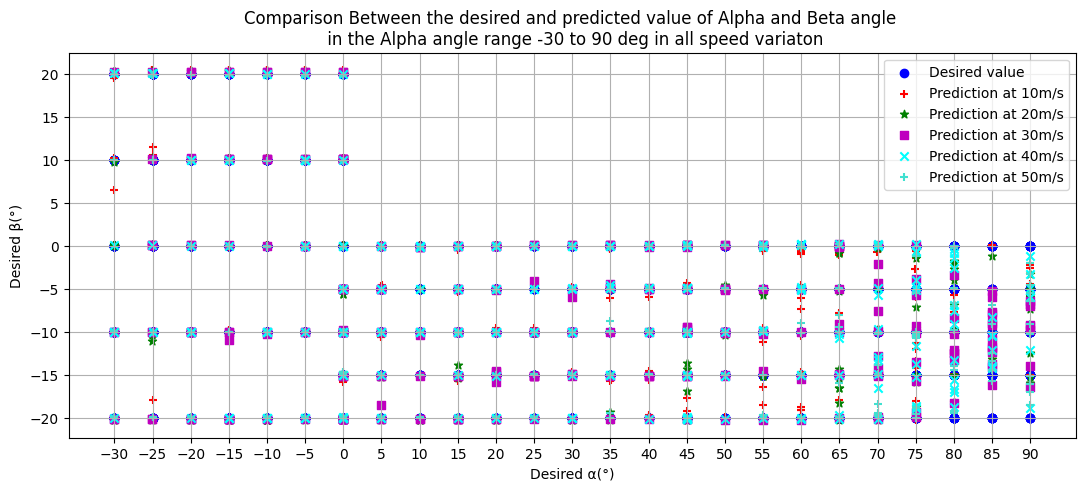

In [18]:
fig = plt.figure(figsize=(13, 5))

# Add first subplot (Alpha vs Beta)
ax1 = fig.add_subplot()
ax1.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
ax1.scatter(y0_pred_10["α"], y0_pred_10["β"], label = 'Prediction at 10m/s', marker='+', color='r')
ax1.scatter(y0_pred_20["α"], y0_pred_20["β"], label = 'Prediction at 20m/s', marker='*', color='green')
ax1.scatter(y0_pred_30["α"], y0_pred_30["β"], label = 'Prediction at 30m/s', marker='s', color='m')
ax1.scatter(y0_pred_40["α"], y0_pred_40["β"], label = 'Prediction at 40m/s', marker='x', color='cyan')
ax1.scatter(y0_pred_50["α"], y0_pred_50["β"], label = 'Prediction at 50m/s', marker='+', color='turquoise')
ax1.set_xlabel("Desired α(°)")
ax1.set_ylabel("Desired β(°)")
ax1.set_xticks(np.arange(-30, 95, 5))
ax1.set_yticks(np.arange(-20, 25, 5))
ax1.set_title('Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg in all speed variaton')
ax1.grid(True)
ax1.legend()

plt.savefig('model_2_all_after_pruning.png', format='png', dpi=1000)
plt.show()

In [19]:
# y_pred = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# fig, axes = plt.subplots(5, 1, figsize=(10,30))
# speed = 10
# # Add first subplot (Alpha vs Beta)
# for i, V in enumerate(y_pred):
#     ax = axes[i]
#     ax.scatter(y0_test["α"], y0_test["β"], label = 'Desired value', marker='o', color='b')
#     ax.scatter(V["α"], V["β"], label = f'Prediction at {speed} m/s', marker='+', color='r')
#     ax.set_xlabel("Desired α(°)")
#     ax.set_ylabel("Desired β(°)")
#     ax.set_xticks(np.arange(-30, 95, 5))
#     ax.set_yticks(np.arange(-20, 25, 5))
#     ax.set_title(f'Comparison Between the desired and predicted value of Alpha and Beta angle \n in the Alpha angle range -30 to 90 deg for {speed} m/s')
#     ax.grid(True)
#     speed += 10
    

# plt.savefig('model_2_every_after_pruning.png', format='png', dpi=1000)
# plt.tight_layout()
# plt.show()

0.036471986725530314 1192 
 V              10.057256
α              75.000000
β               0.000000
alpha_error     0.036472
Name: 1192, dtype: float64
-0.03393778159197325 1038 
 V              10.012088
α              60.000000
β              -5.000000
alpha_error    -0.033938
Name: 1038, dtype: float64
0.02057696303222656 2154 
 V              20.035432
α              45.000000
β             -20.000000
alpha_error     0.020577
Name: 2154, dtype: float64
-0.027826744214365817 2251 
 V              20.068093
α              50.000000
β             -20.000000
alpha_error    -0.027827
Name: 2251, dtype: float64
0.03582911742168449 3980 
 V              30.024409
α              85.000000
β               0.000000
alpha_error     0.035829
Name: 3980, dtype: float64
-0.008326785979818396 3891 
 V              30.040972
α              80.000000
β             -20.000000
alpha_error    -0.008327
Name: 3891, dtype: float64
0.020530878010106335 5338 
 V              40.071150
α              90

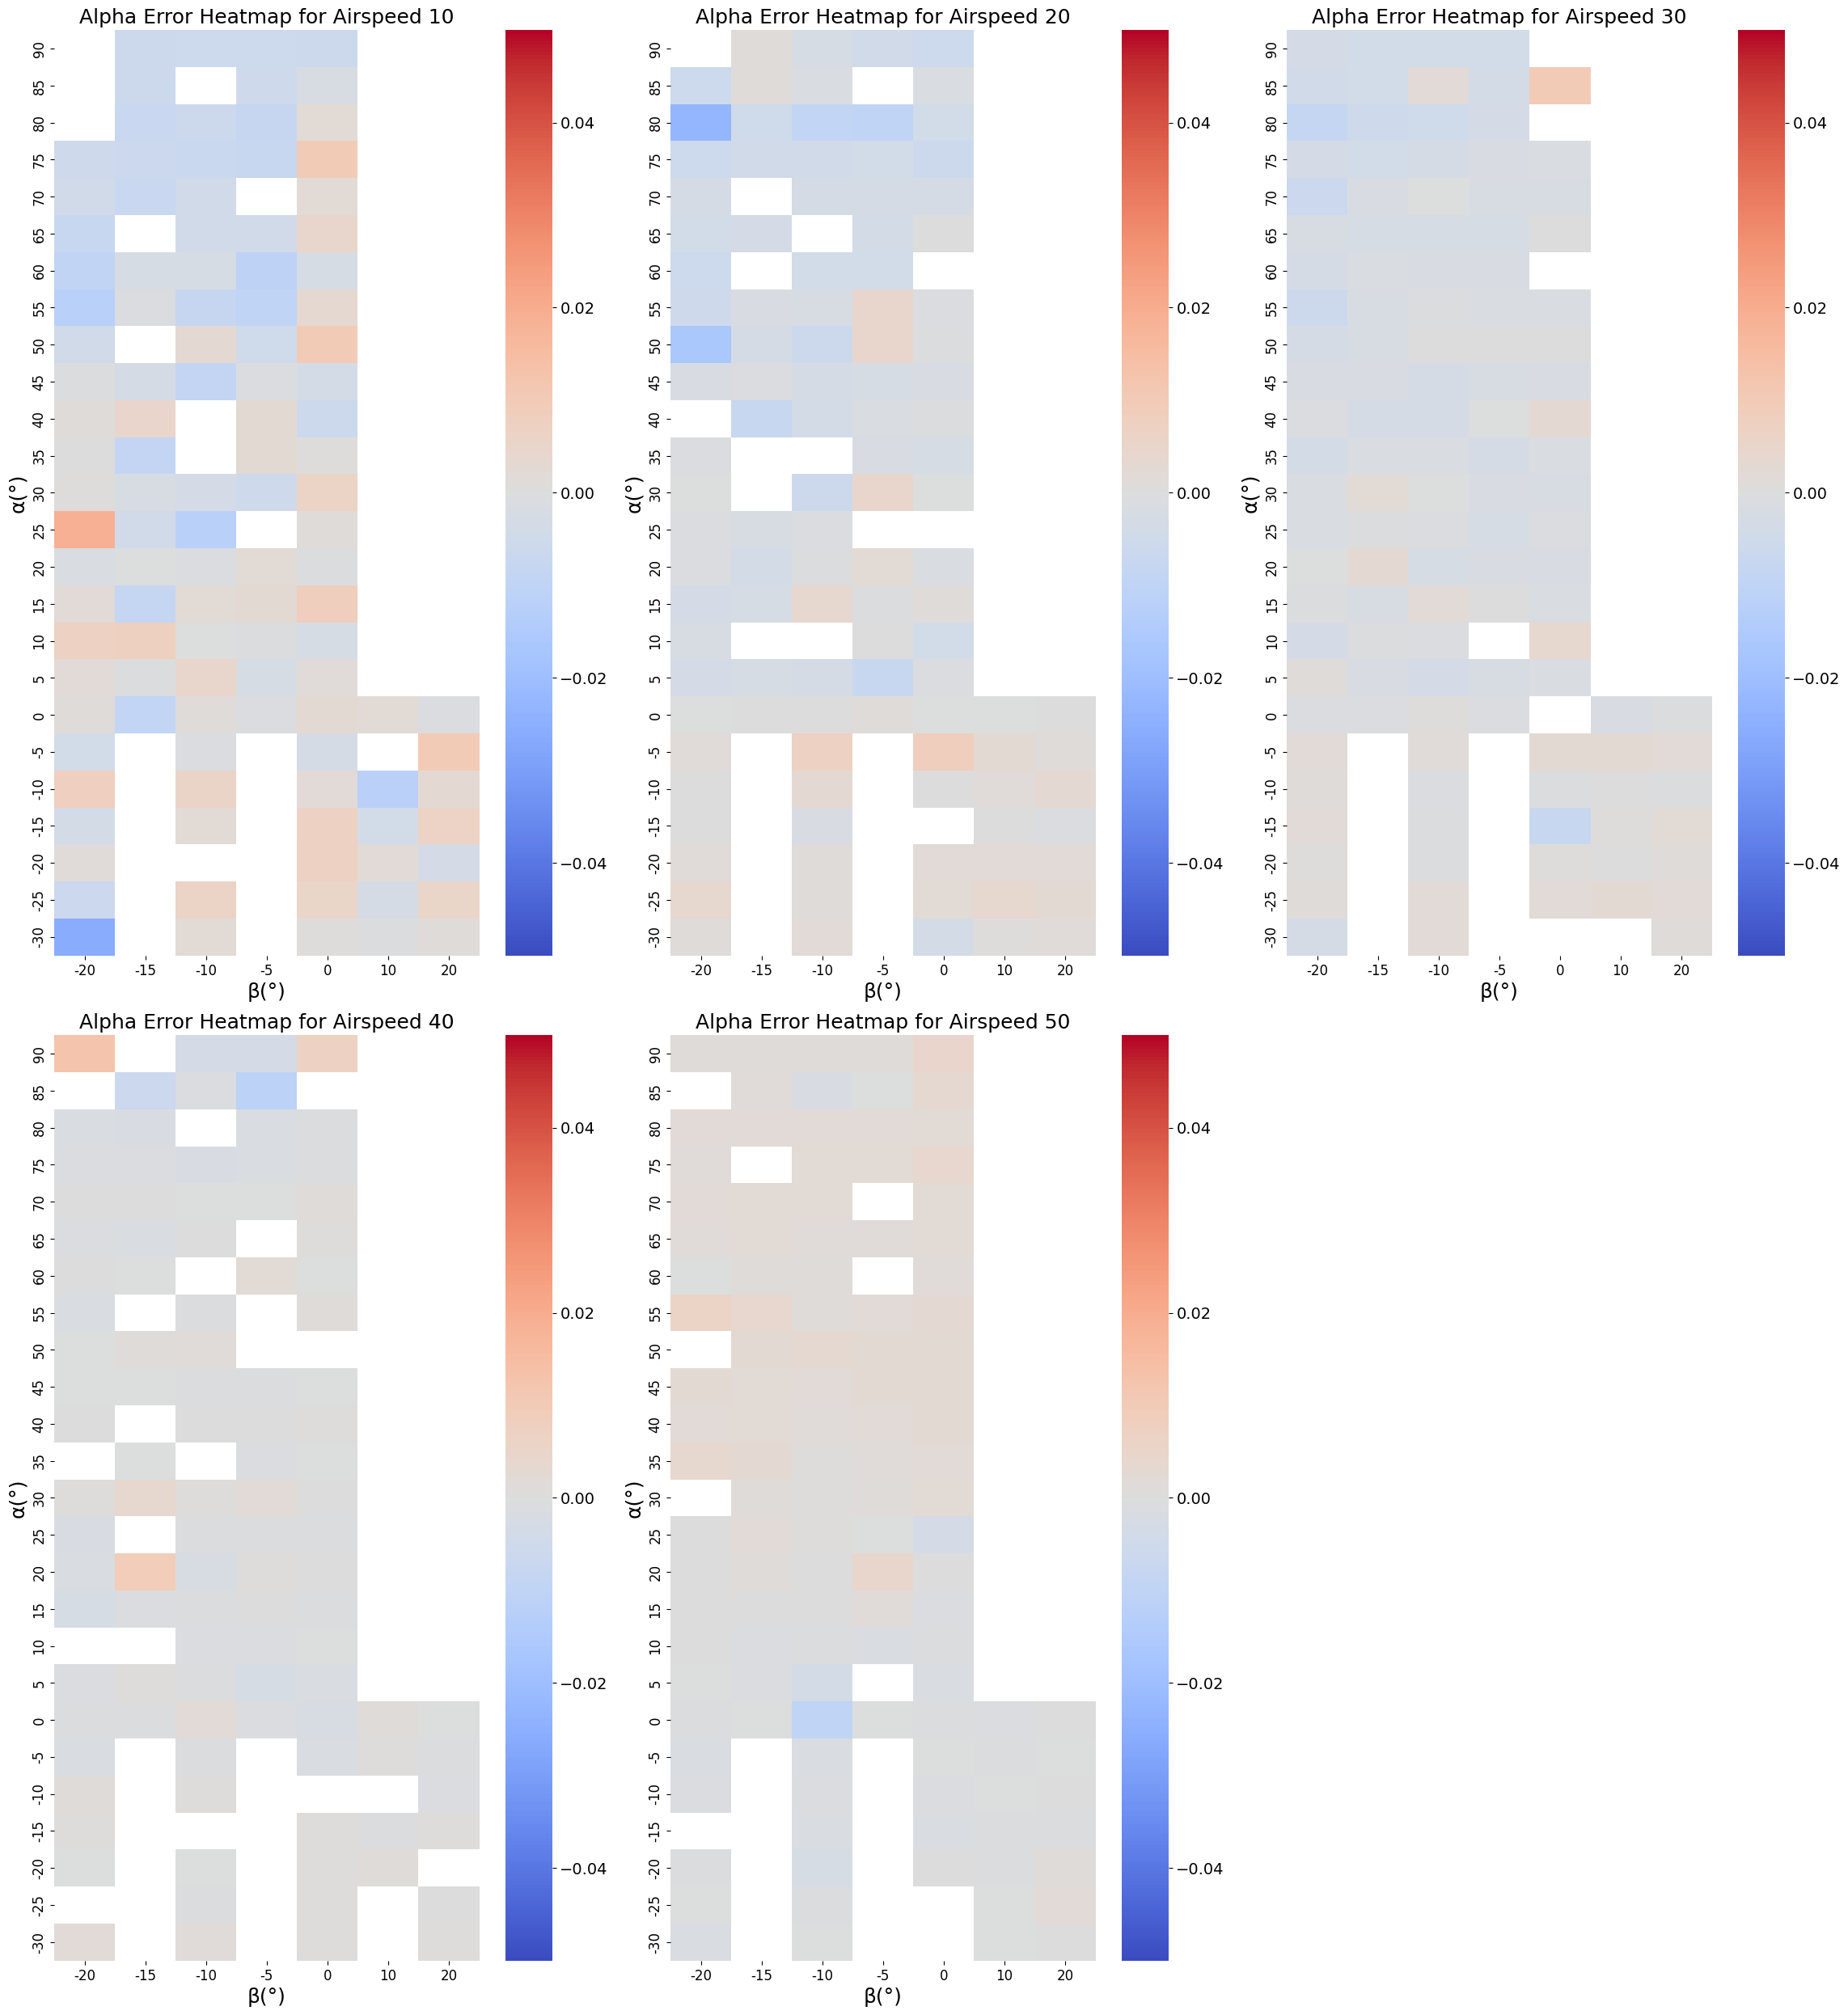

In [20]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    print(actual['alpha_error'].max(), actual['alpha_error'].idxmax(), '\n', actual.loc[actual['alpha_error'].idxmax()] )
    print(actual['alpha_error'].min(), actual['alpha_error'].idxmin(), '\n', actual.loc[actual['alpha_error'].idxmin()] )
    actual['beta_error'] = beta_values_act - beta_values_pred
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='alpha_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -0.05,
        vmax = 0.05
    )
    ax.set_title(f'Alpha Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_2_heatmap_alpha_after_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()

7.03716556610582 1181 
 V              10.023695
α              75.000000
β              -5.000000
alpha_error    -0.008765
beta_error      7.037166
Name: 1181, dtype: float64
-9.269309730548589 1261 
 V              10.087213
α              85.000000
β             -15.000000
alpha_error    -0.005837
beta_error     -9.269310
Name: 1261, dtype: float64
9.831913745658483 2589 
 V              20.006058
α              80.000000
β               0.000000
alpha_error    -0.004167
beta_error      9.831914
Name: 2589, dtype: float64
-8.147637950648472 2559 
 V              20.037151
α              80.000000
β             -15.000000
alpha_error    -0.004720
beta_error     -8.147638
Name: 2559, dtype: float64
8.508382273758055 3877 
 V              30.010884
α              75.000000
β              -5.000000
alpha_error    -0.000495
beta_error      8.508382
Name: 3877, dtype: float64
-9.126358540516804 3940 
 V              30.000000
α              85.000000
β             -20.000000
alpha_error  

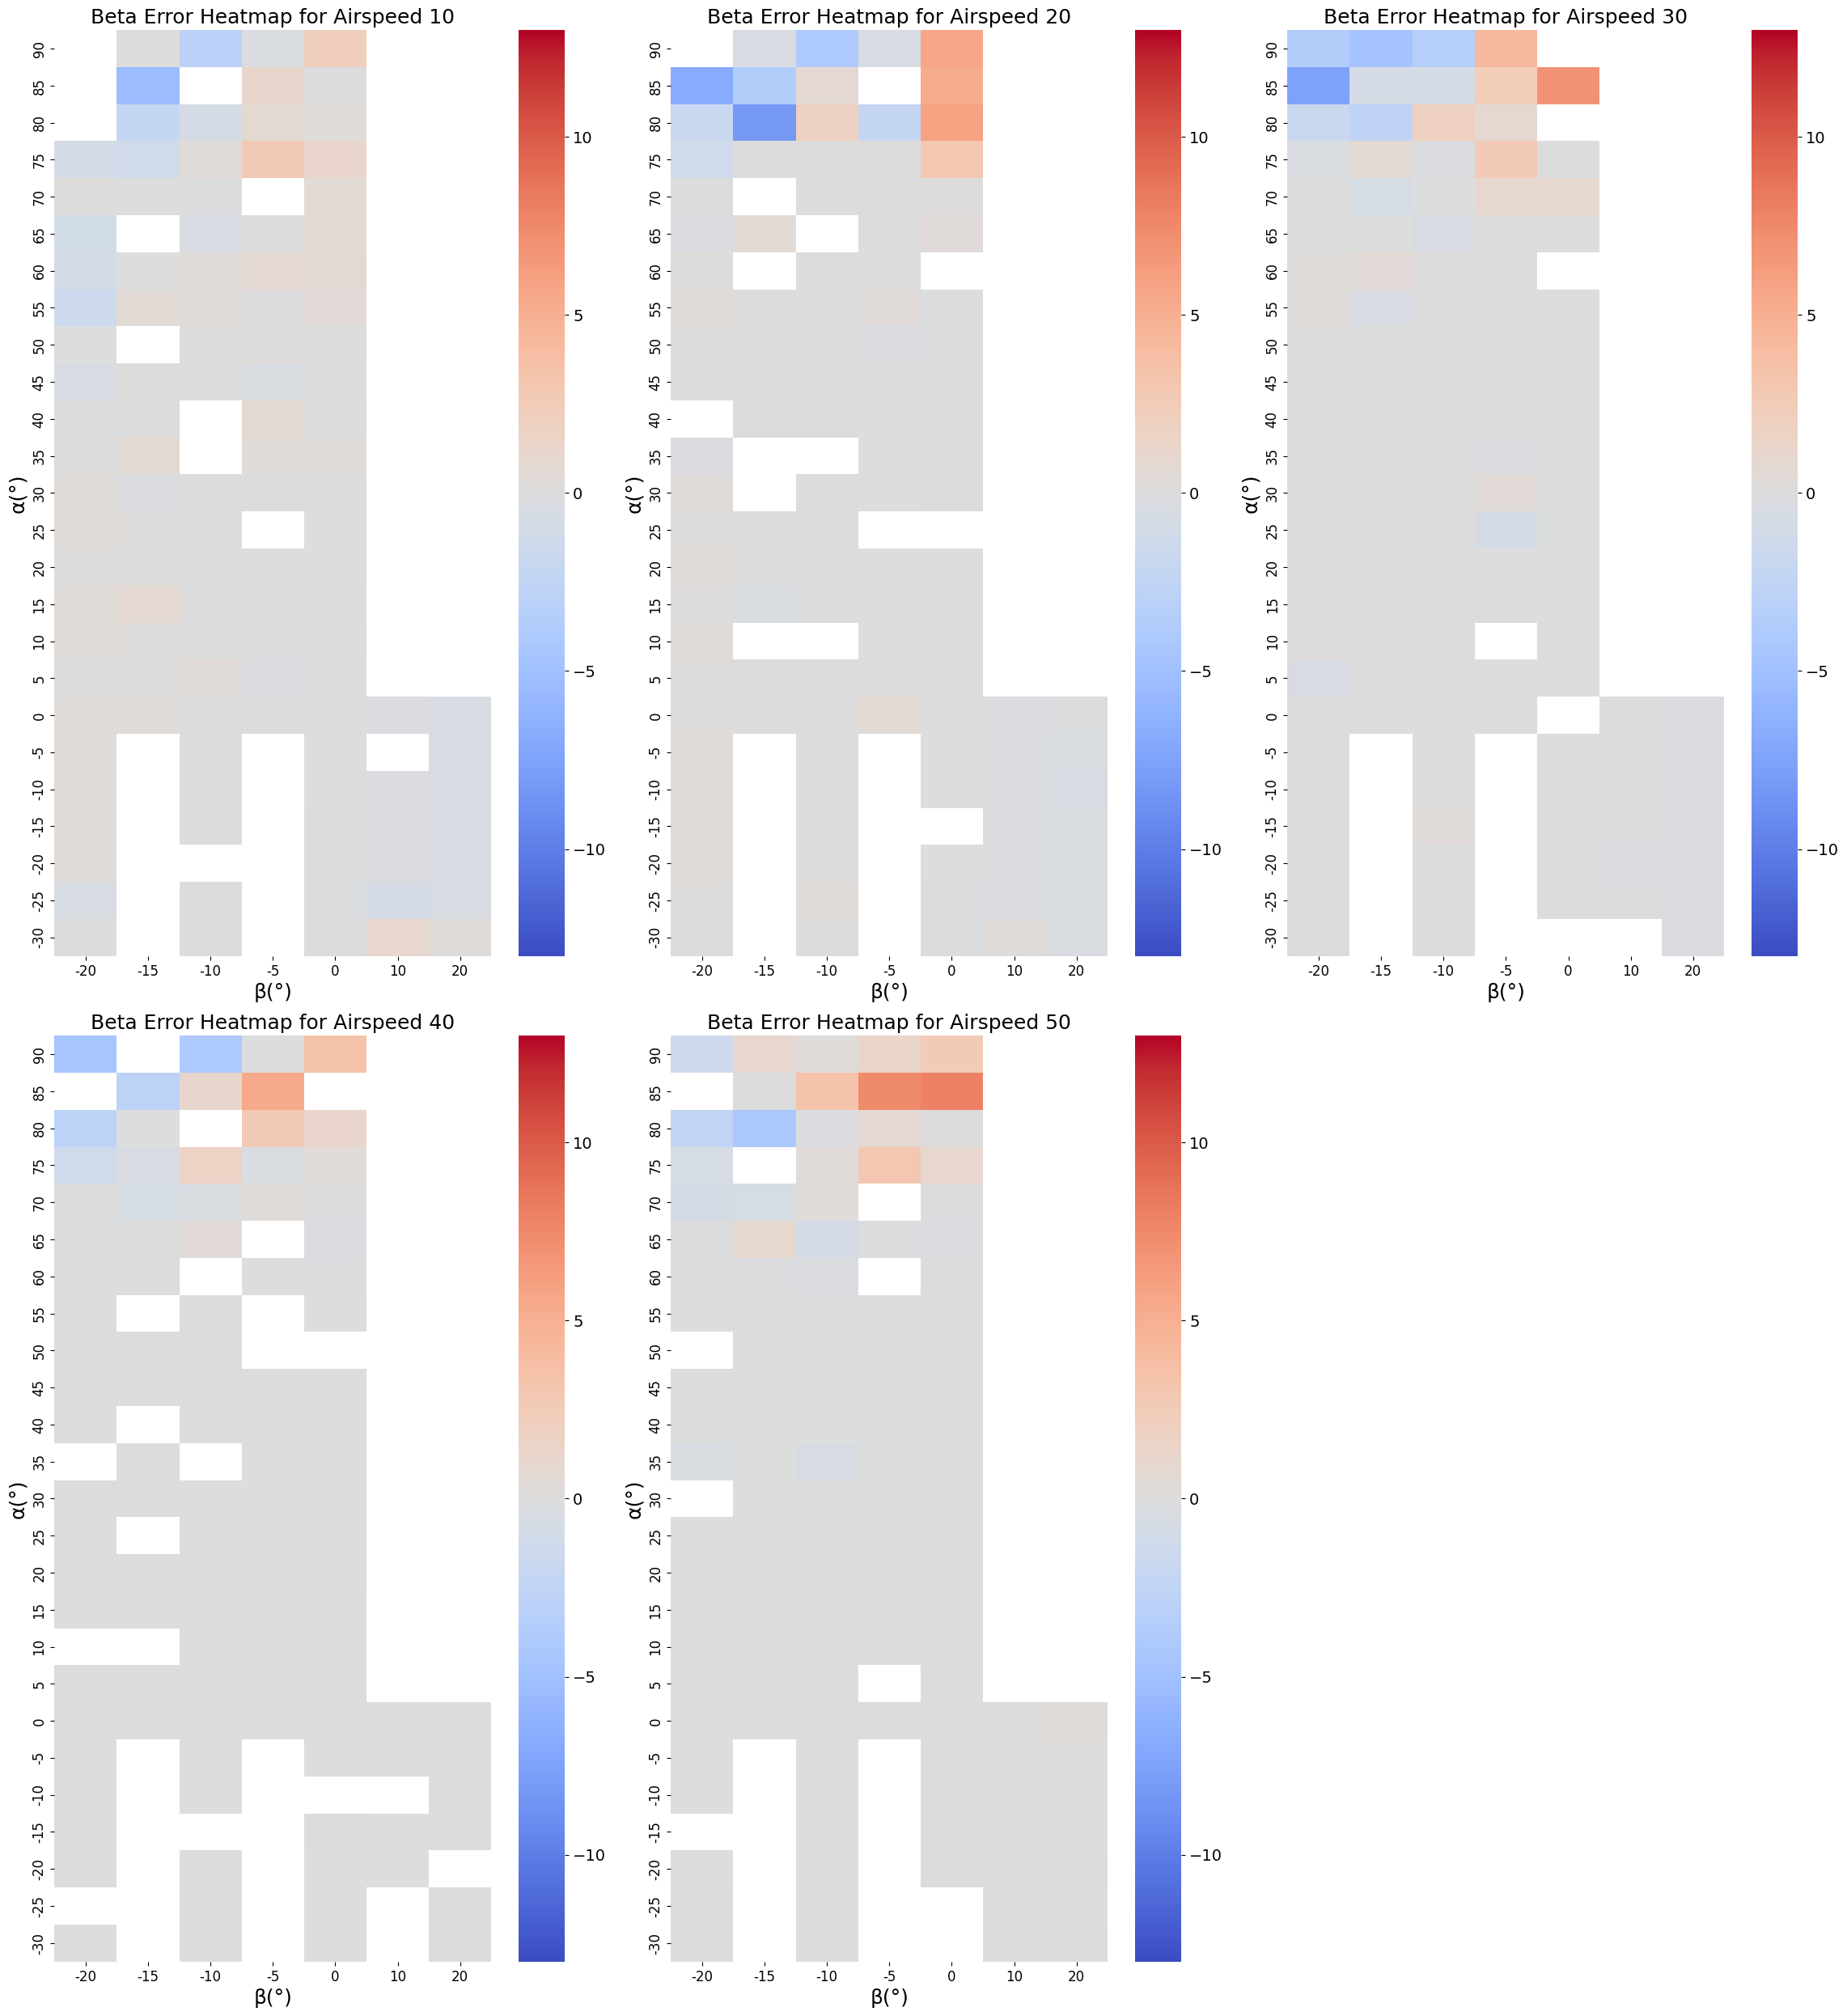

In [21]:
pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

fig, axes = plt.subplots(2, 3, figsize=(23, 25))
axes = axes.flatten()
for i in range(len(pred_result)):
    actual = act_result[i].copy()
    alpha_values_pred = pred_result[i]["α"]
    beta_values_pred = pred_result[i]["β"]
    alpha_values_act = act_result[i]["α"]
    beta_values_act = act_result[i]["β"]
    actual['alpha_error'] = alpha_values_act - alpha_values_pred
    actual['beta_error'] = beta_values_act - beta_values_pred
    print(actual['beta_error'].max(), actual['beta_error'].idxmax(), '\n', actual.loc[actual['beta_error'].idxmax()] )
    print(actual['beta_error'].min(), actual['beta_error'].idxmin(), '\n', actual.loc[actual['beta_error'].idxmin()] )
    ax = axes[i]
    pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
    heatmap = sns.heatmap(
        pivot_table,
        cmap='coolwarm',
        ax = axes [i],
        vmin = -13,
        vmax = 13
    )
    ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}', fontsize = 18)
    ax.set_xlabel("β(°)",fontsize = 18)
    ax.set_ylabel("α(°)", fontsize = 18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.invert_yaxis()
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=14)
for j in range(len(pred_result), len(axes)):
    axes[j].axis('off')
plt.savefig('model_2_heatmap_beta_after_pruning.png', format='png', dpi=1200, bbox_inches='tight')
plt.tight_layout(pad=1.0) 
plt.show()
# pred_result = [y0_pred_10, y0_pred_20, y0_pred_30, y0_pred_40, y0_pred_50]
# act_result = [y0_test_10, y0_test_20, y0_test_30, y0_test_40, y0_test_50]

# fig, axes = plt.subplots(2, 3, figsize=(20, 15))
# axes = axes.flatten()
# for i in range(len(pred_result)):
#     actual = act_result[i].copy()
#     alpha_values_pred = pred_result[i]["α"]
#     beta_values_pred = pred_result[i]["β"]
#     alpha_values_act = act_result[i]["α"]
#     beta_values_act = act_result[i]["β"]
#     actual['alpha_error'] = alpha_values_act - alpha_values_pred
#     actual['beta_error'] = beta_values_act - beta_values_pred
#     ax = axes[i]
#     pivot_table = actual.pivot_table(index='α', columns='β', values='beta_error')
#     sns.heatmap(
#         pivot_table,
#         cmap='coolwarm',
#         ax = axes [i],
#     )
#     ax.set_title(f'Beta Error Heatmap for Airspeed {10+i*10}')
#     ax.set_xlabel("β(°)")
#     ax.set_ylabel("α(°)")
#     ax.invert_yaxis()
# for j in range(len(pred_result), len(axes)):
#     axes[j].axis('off')
# plt.savefig('model_1_heatmap_beta_before_pruning.png', format='png', dpi=1500)
# plt.tight_layout(rect=[0, 0, 0.9, 1]) 
# plt.show()